In [64]:
import sys
from sqlalchemy import create_engine
import string
import psycopg2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split, cross_val_score

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.tag.perceptron import PerceptronTagger
from nltk.tokenize import word_tokenize

In [2]:
engine = create_engine('postgresql://teresaborcuch@localhost:5433/capstone')

In [16]:
query = "SELECT DISTINCT ON(title) title, date, author, body, link, section FROM fox_news;"
fox_data = pd.read_sql(query, engine)

In [17]:
query = "SELECT DISTINCT ON(title) title, date, author, body, link, section FROM ny_times;"
nyt_data = pd.read_sql(query, engine)

In [18]:
query = "SELECT DISTINCT ON(title) title, date, author, body, link, section FROM washington_post;"
wp_data = pd.read_sql(query, engine)

In [38]:
wp_data['source'] = ['WP']*len(wp_data)

In [39]:
fox_data['source'] = ['Fox']*len(fox_data)
nyt_data['source'] = ['NYT'] * len(nyt_data)

In [52]:
fox_data.head(50)

,title,date,author,body,link,section,source
0,'Code Black' cast teases shocking season finale,2017-02-08,By \t\n\t\t \n\n\t\t ...,"CBS ""Code Black"" will air its season finale on...",/entertainment/2017/02/08/code-black-cast-teas...,entertainment,Fox
1,'Fifty Shades' cast banned from dirty talk,2017-02-06,By \t\n\t\t \n\t\t ...,For the purveyors of the most famous erotic fi...,/entertainment/2017/02/06/fifty-shades-cast-ba...,entertainment,Fox
2,'Focus on American Workers First': Cotton's Bi...,2017-02-07,by Fox News Insider,"On Tuesday, Sen. Tom Cotton (R-AR) and David P...",/2017/02/07/tom-cotton-legislation-would-cut-l...,politics,Fox
3,'Hiring Vets Is Who We Are': Black Rifle Coffe...,2017-02-07,by Fox News Insider,In response to Starbucks announcing it would h...,/2017/02/07/black-rifle-coffee-company-plans-h...,politics,Fox
4,"'Humblebrag,' 'Binge-Watch' & 'Throw Shade' Am...",2017-02-08,by Fox News Insider,"We just added more than 1,000 new words to the...",/2017/02/08/dictionary-1000-new-words-merriam-...,politics,Fox
5,'I Find It a Little Sexist': McCain Blasts Dem...,2017-02-07,by Fox News Insider,"Meghan McCain said today on ""Outnumbered"" that...",/2017/02/07/mccain-dems-attacks-betsy-devos-li...,politics,Fox
6,'Mud Dragon' dinosaur unearthed in China,2016-11-11,By \t\n\t\t \n\n\t\t ...,A new species of birdlike dinosaur was recentl...,/science/2016/11/11/mud-dragon-dinosaur-uneart...,science,Fox
7,'Punch a Nazi' goes from meme to video game,2017-02-08,None found,The recent punch a Nazi meme has inspired a vi...,/tech/2017/02/08/punch-nazi-goes-from-meme-to-...,tech,Fox
8,'The Insider' canceled after 12 years on the air,2017-02-07,By \t\n\t\t \n\n\t\t ...,The long-running entertainment news show The I...,/entertainment/2017/02/07/insider-canceled-aft...,entertainment,Fox
9,10 surprising scientific facts about twins,2017-02-07,By \t\n\t\t \n\t\t ...,Beyonc is pregnant with twins! The singer and ...,/health/2017/02/07/10-surprising-scientific-fa...,health,Fox


In [40]:
fox_data['section'].replace('Fox News, Fox News Channel, Fox News Insider, Official Blog, News, Headlines, Politics', 'politics', inplace = True)

In [41]:
wp_data['section'].value_counts()

opinions                       48
world                          42
lifestyle/style                41
sports                         27
world/europe                   25
politics                       24
lifestyle/food                 20
sports/highschools             13
world/middle_east              13
world/national-security        13
entertainment/music            10
world/asia_pacific              9
lifestyle/kidspost              8
entertainment/books             8
world/the_americas              8
powerpost                       8
business/economy                7
entertainment                   7
world/africa                    7
national/health-science         7
lifestyle                       7
local/education                 6
entertainment/celebrities       6
entertainment/museums           5
local                           4
lifestyle/home                  4
entertainment/tv                3
local/obituaries                3
local/virginia-politics         2
lifestyle/trav

In [42]:
# merge the dataframes into one big one
data = pd.concat([nyt_data, fox_data, wp_data], axis = 0)

In [53]:
# make a dummy opinion column
data['opinion'] = [1 if "pinion" in x else 0 for x in data['section']]

In [58]:
def compute_score(sentence):
    tagger = PerceptronTagger()
    taggedsentence = []
    sent_score = []
    taggedsentence.append(tagger.tag(sentence.split()))
    wnl = nltk.WordNetLemmatizer()
    for idx, words in enumerate(taggedsentence):
        for idx2, t in enumerate(words):
            newtag = ''
            lemmatizedsent = wnl.lemmatize(t[0])
            if t[1].startswith('NN'):
                newtag = 'n'
            elif t[1].startswith('JJ'):
                newtag = 'a'
            elif t[1].startswith('V'):
                newtag = 'v'
            elif t[1].startswith('R'):
                newtag = 'r'
            else:
                newtag = ''
            if (newtag != ''):
                synsets = list(swn.senti_synsets(lemmatizedsent, newtag))
                score = 0.0
                if (len(synsets) > 0):
                    for syn in synsets:
                        score += syn.pos_score() - syn.neg_score()
                    sent_score.append(score / len(synsets))
        if (len(sent_score)==0 or len(sent_score)==1):
            return (float(0.0))
        else:
            return (sum([word_score for word_score in sent_score]) / (len(sent_score)))

In [152]:
data['SA_body'] = [compute_score(x) for x in data['body']]

In [153]:
data['SA_title'] = [compute_score(x) for x in data['title']]

In [176]:
data.to_csv('/Users/teresaborcuch/capstone_project/article_data.csv', encoding = 'utf8')

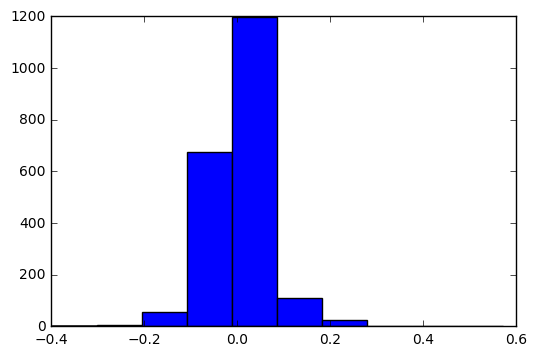

In [159]:
sa_diff = data['SA_body'] - data['SA_title']
plt.hist(sa_diff)
plt.show()

In [164]:
max(sa_diff)

0.57105276423098084

In [162]:
data.head(1)

,title,date,author,body,link,section,source,opinion,entertainment,business,SA_body,SA_title,SA_diff
0,$5 Million for a Super Bowl Ad. Another Millio...,20170129,Sapna Maheshwari,"This month, Anheuser-Busch InBev hosted a doze...",http://www.nytimes.com/2017/01/29/business/5-m...,business,NYT,0,0,1,0.01624,-0.023148,0.039388


If SA of body is higher than title, SA_diff is positive. If the SA of title is higher, it's negative

In [173]:
data['SA_diff'] = sa_diff
for i, row in data.iterrows():
    if row[12] > 0.2:
        print row[0], ' , ', row[6], ' , ', row[5]

A Birder’s Heaven: Just Follow the Stench to the Landfill  ,  NYT  ,  science
A Personal Trainer for Heartbreak  ,  NYT  ,  style
A Son in Rehab, a Dying Parent: How to Bring Them Together?  ,  NYT  ,  fashion
An Apology for a Lynching  ,  NYT  ,  opinion
An Apology to ... the World  ,  NYT  ,  opinion
Donald Trump’s Mexico Tantrum  ,  NYT  ,  opinion
Dumping a Bad App? Tips for a Painless Breakup  ,  NYT  ,  technology
François Fillon Blames ‘Media Lynching’ for His Campaign Crisis  ,  NYT  ,  world
Good, Bad and Mad: Andrew Rosenthal on the News  ,  NYT  ,  insider
Mavericks, a Premier Surfing Event, Is Canceled Amid Financial Woes  ,  NYT  ,  sports
Messages About iMessages, but Not From Apple  ,  NYT  ,  technology
Mr. Trump’s Bad Two-for-One Deal  ,  NYT  ,  opinion
No, Trump, Not on Our Watch  ,  NYT  ,  opinion
Patriots’ Julian Edelman and Danny Amendola Are Feared, if Not Flashy  ,  NYT  ,  sports
Review: ‘Powerless’ on NBC Has Cubicles, Not Capes  ,  NYT  ,  arts
Stephen Schwa

In [61]:
mask = (data['opinion'] == 1)
opinion_articles = data[mask]

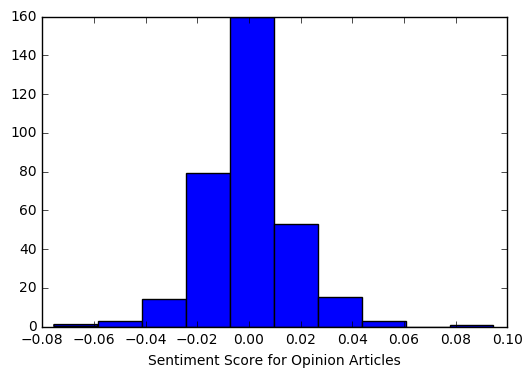

Mean Score:  0.000633290135108
Max Score:  0.094696969697
Min Score:  -0.0754667375635


In [67]:
op_body_scores = []
for x in opinion_articles['body']:
    score = compute_score(x)
    op_body_scores.append(score)
    
plt.hist(op_body_scores)
plt.xlabel('Sentiment Score for Opinion Articles')
plt.show()

print "Mean Score: ", np.mean(op_body_scores)
print "Max Score: ", max(op_body_scores)
print "Min Score: ", min(op_body_scores)

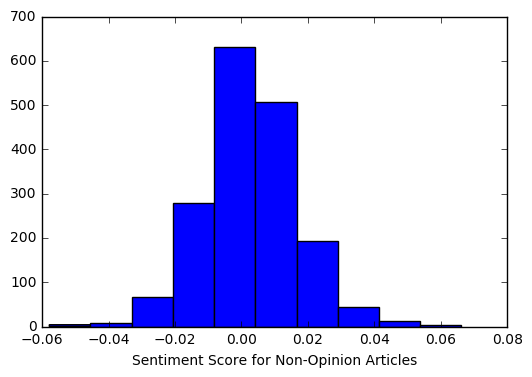

Mean Score:  0.00247802573225
Max Score:  0.0662166693245
Min Score:  -0.057865051735


In [69]:
mask = (data['opinion'] == 0)
nonop_articles = data[mask]
nonop_body_scores = []

for x in nonop_articles['body']:
    score = compute_score(x)
    nonop_body_scores.append(score)
    
plt.hist(nonop_body_scores)
plt.xlabel('Sentiment Score for Non-Opinion Articles')
plt.show()

print "Mean Score: ", np.mean(nonop_body_scores)
print "Max Score: ", max(nonop_body_scores)
print "Min Score: ", min(nonop_body_scores)

In [91]:
# function to evaluate and plot sentiment scores for different article breakdowns
def eval_sa_and_plot(category, value, doc_division):
    mask = (data[category] == value)
    selected_articles = data[mask]
    scores = []
    
    for x in selected_articles[doc_division]:
        score = compute_score(x)
        scores.append(score)
        
    plt.hist(scores)
    plt.xlabel("Sentiment Score for {} = {}".format(category, value))
    plt.show()
    
    print "Mean Score: ", np.mean(scores)
    print "Max Score: ", max(scores)
    print "Min Score: ", min(scores)

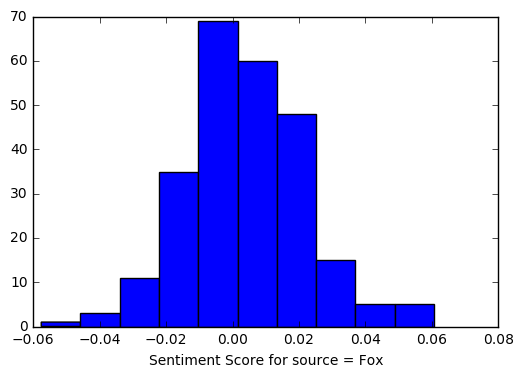

Mean Score:  0.00390727321106
Max Score:  0.0605964339717
Min Score:  -0.0576155656096


In [94]:
eval_sa_and_plot('source', 'Fox', 'body')

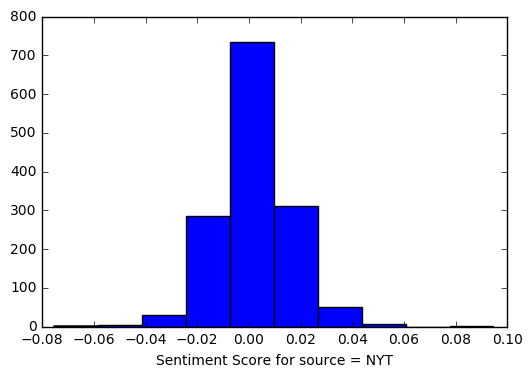

Mean Score:  0.00212404512618
Max Score:  0.094696969697
Min Score:  -0.0754667375635


In [95]:
eval_sa_and_plot('source', 'NYT', 'body')

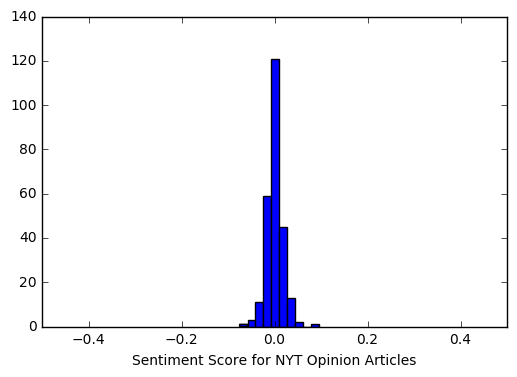

Mean Score:  0.0011577104053
Max Score:  0.094696969697
Min Score:  -0.0754667375635


In [112]:
# look at fox opinion vs nyt opinion
mask = ((data['source'] == 'NYT') & (data['opinion'] == 1))
articles = data[mask]
scores = []

for x in articles['body']:
    score = compute_score(x)
    scores.append(score)
    
plt.hist(scores)
plt.xlabel('Sentiment Score for NYT Opinion Articles')
plt.xlim(-0.5,0.5)
plt.show()

print "Mean Score: ", np.mean(scores)
print "Max Score: ", max(scores)
print "Min Score: ", min(scores)

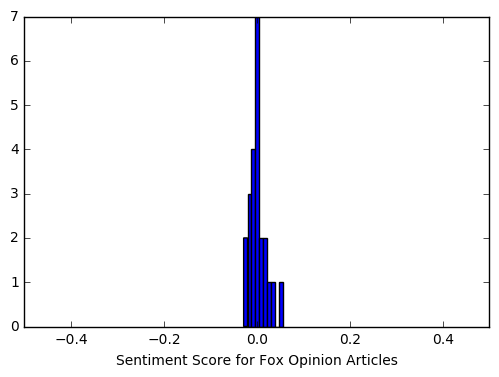

Mean Score:  0.00216754538455
Max Score:  0.0549940097399
Min Score:  -0.0285837085243


In [110]:
# look at fox opinion vs nyt opinion
mask = ((data['source'] == 'Fox') & (data['opinion'] == 1))
articles = data[mask]
scores = []

for x in articles['body']:
    score = compute_score(x)
    scores.append(score)
    
plt.hist(scores)
plt.xlabel('Sentiment Score for Fox Opinion Articles')
plt.xlim(-0.5,0.5)
plt.show()

print "Mean Score: ", np.mean(scores)
print "Max Score: ", max(scores)
print "Min Score: ", min(scores)

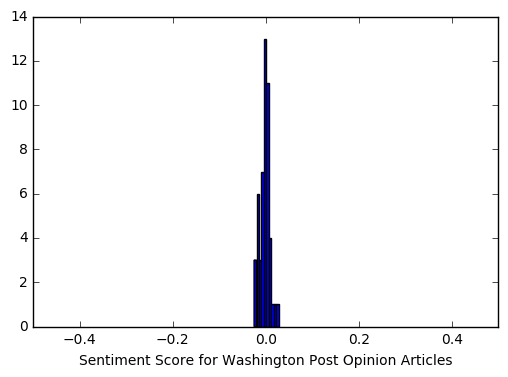

Mean Score:  -0.00275749906302
Max Score:  0.0274958768645
Min Score:  -0.0252234296686


In [111]:
# look at wp opinion
mask = ((data['source'] == 'WP') & (data['opinion'] == 1))
articles = data[mask]
scores = []

for x in articles['body']:
    score = compute_score(x)
    scores.append(score)
    
plt.hist(scores)
plt.xlabel('Sentiment Score for Washington Post Opinion Articles')
plt.xlim(-0.5,0.5)
plt.show()

print "Mean Score: ", np.mean(scores)
print "Max Score: ", max(scores)
print "Min Score: ", min(scores)

In [115]:
mask = ((data['source'] == 'NYT') & (data['opinion'] == 1))
articles = data[mask]

for i, row in articles.iterrows():
    if compute_score(row[3]) > 0.09:
        print row[0]
        print row[3]

Trump’s Border Wall
It’s a brave new world.


In [120]:
articles

,title,date,author,body,link,section,source,opinion
10,4.1 Miles,20160928,Daphne Matziaraki,Note: This documentary short film was nominate...,http://www.nytimes.com/2016/09/28/opinion/4-1-...,opinion,NYT,1
19,A Blow to Myanmar’s Democracy,20170203,The Editorial Board,"The murder of U Ko Ni, a prominent Muslim lawy...",https://www.nytimes.com/2017/02/03/opinion/a-b...,opinion,NYT,1
20,A Concerned Citizen’s Plea to America’s Busine...,20170201,Thomas L. Friedman,Dear America’s Business Leaders:I am writing y...,https://www.nytimes.com/2017/02/01/opinion/a-c...,opinion,NYT,1
21,A Conservative Case for Climate Action,20170208,"Martin S. Feldstein, Ted Halstead and N. Grego...","CRAZY as it may sound, this is the perfect tim...",https://www.nytimes.com/2017/02/08/opinion/a-c...,opinion,NYT,1
22,A Crime in the Cancer Lab,20170128,Theodora Ross,The detective work we do in my lab involves ge...,http://www.nytimes.com/2017/01/28/opinion/sund...,opinion,NYT,1
25,A Diplomat’s Proper Channel of Dissent,20170131,Paul D. Wolfowitz,"Organizations, particularly large ones, have a...",https://www.nytimes.com/2017/01/31/opinion/a-d...,opinion,NYT,1
32,A Government on Edge and in the Dark,20170131,The Editorial Board,"So this is where we are, just under two weeks ...",https://www.nytimes.com/2017/01/31/opinion/a-g...,opinion,NYT,1
33,A Housing Crisis for Seniors,20170128,Allison Arieff,"Last fall, I had to take the car keys away fro...",http://www.nytimes.com/2017/01/28/opinion/sund...,opinion,NYT,1
35,A Kind of Holocaust Denial,20170130,,To the Editor:Re “Reince Priebus Defends Holoc...,http://www.nytimes.com/2017/01/30/opinion/a-ki...,opinion,NYT,1
36,A Lesson in Black History,20170206,Charles M. Blow,Last week at a supposed Black History Month “l...,https://www.nytimes.com/2017/02/06/opinion/a-l...,opinion,NYT,1


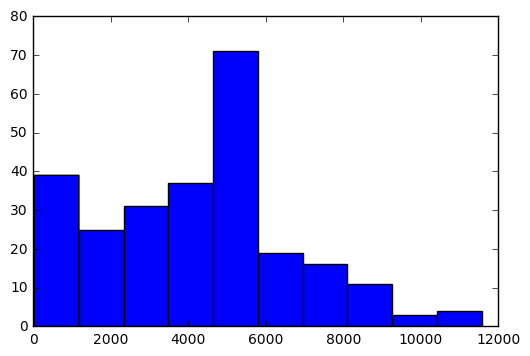

In [126]:
lengths = []
for x in articles['body']:
    lengths.append(len(x))
plt.hist(lengths)
plt.show()

In [128]:
for x in articles['body']:
    if len(x) < 1000:
        print x, '\n'

To the Editor:Re “Reince Priebus Defends Holocaust Statement That Failed to Mention Jews” (nytimes.com, Jan. 30):Of all of President Trump’s actions during his first 10 days in office, among the most egregious was the deliberate omission of Jews from his statement for International Holocaust Remembrance Day.Taking away the intent of the Holocaust may not be the classic form of Holocaust denial, but it is a form of denial nonetheless. This decision is the clearest indication that no historical fact is too big for the Trump administration to try to erase from public consciousness.And most important, it shows that this administration is controlled by people who know truth from fiction, but not right from wrong.MITCHELL TURKERPortland, Ore. 

To the Editor:Re “A Sinister Perception of Islam Now Steers the White House” (front page, Feb. 2):In Sarajevo in the 1990s, I saw my neighbors and family members gunned down by Serbian nationalist snipers. As a result, I, perhaps more than most people

In [129]:
data['section'].value_counts()

world                          263
opinion                        256
us                             250
sports                         178
arts                           127
science                        103
politics                        94
business                        72
health                          56
technology                      55
entertainment                   49
opinions                        48
movies                          41
lifestyle/style                 41
fashion                         38
nyregion                        27
theater                         26
world/europe                    25
Opinion                         23
tech                            21
lifestyle/food                  20
well                            17
books                           15
sports/highschools              13
education                       13
world/middle_east               13
world/national-security         13
entertainment/music             10
style               

In [144]:
data['entertainment'] = [1 if ('entertainment' in x) | ('movie' in x) | ('theater' in x) else 0 for x in data['section']]
data['business'] = [1 if 'business' in x else 0 for x in data['section']]

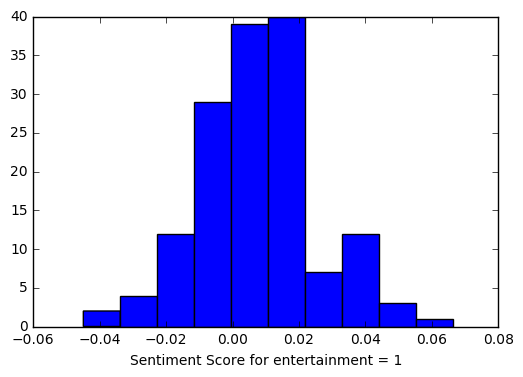

Mean Score:  0.00753466148535
Max Score:  0.0662166693245
Min Score:  -0.0449425298739


In [145]:
eval_sa_and_plot('entertainment',1,'body')

In [146]:
data.head(1)

,title,date,author,body,link,section,source,opinion,entertainment,business
0,$5 Million for a Super Bowl Ad. Another Millio...,20170129,Sapna Maheshwari,"This month, Anheuser-Busch InBev hosted a doze...",http://www.nytimes.com/2017/01/29/business/5-m...,business,NYT,0,0,1


In [147]:
for i, x in data.iterrows():
    if (x[8] == 1) and (compute_score(x[3]) > 0.05):
        print x[0]

‘La La Land’ Takes Top Prize at the Producers Guild Awards
Anthony Bourdain relieved to no longer pretend to be together with wife 
Arevalo’s “The Fury of a Patient Man” wins Goya best picture


In [150]:
for i, x in data.iterrows():
    if compute_score(x[3]) > 0.05:
        print x[0]

Buy Less, Pay More
Street Style: Paris Couture
Trump’s Border Wall
‘La La Land’ Takes Top Prize at the Producers Guild Awards
Anthony Bourdain relieved to no longer pretend to be together with wife 
Better sex, better health, more money: What men really get out of marriage 
Great Valentine's Day Gifts for Music Lovers 
This song was created with one goal: make babies happy 
Arevalo’s “The Fury of a Patient Man” wins Goya best picture


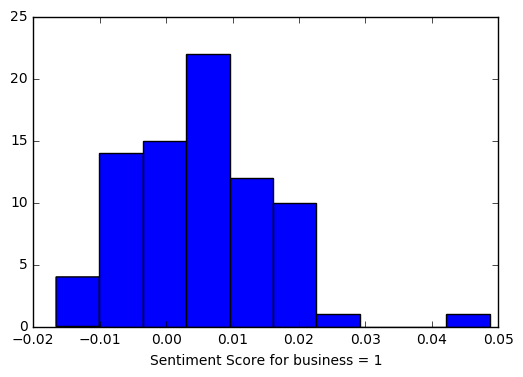

Mean Score:  0.0049350910916
Max Score:  0.0487048017373
Min Score:  -0.0165758480987


In [141]:
eval_sa_and_plot('business',1,'body')